In [21]:
#import สิ่งที่จะใช้
import os
#import keras
#from keras import optimizers
#from keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import pandas as pd
#from tensorflow.python.keras import optimizer_v2
import cv2
#import matplotlib.image as mpimg
from matplotlib import pyplot  as plt
import numpy as np  
import tensorflow as tf
#from PIL import Image
#from tensorflow.keras.optimizers import Adam
from pathlib import Path

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D
#from keras.callbacks import CSVLogger

In [22]:
#!!!!!! สำคัญ แก้ให้ถูกก่อนรัน!!!!!!

#สำหรับรันบน colab 
'''
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)
picForTestTrain = "/content/gdrive/MyDrive/Colab Notebooks/Project/Dog_dataset" #กำหนด path ของ folder ที่เก็บภาพที่จะใช้ในการเรียนรู้ 
unseen = "/content/gdrive/MyDrive/Colab Notebooks/Project/unseen" #กำหนด path ของ Folder ที่เก็บรูปภาพ unseen
'''

#สำหรับรันบนเครื่องตัวเอง
picForTestTrain = str(Path().resolve())+"/Dog_dataset" #กำหนด path ของ folder ที่เก็บภาพที่จะใช้ในการเรียนรู้ (str(Path().resolve()) หมายถึงตำแหน่งตรงนี้)
unseen = "C:/AI/ans/" #กำหนด path ของ Folder ที่เก็บรูปภาพ unseen

In [23]:
#กำหนดตัวแปรสำหรับการกัน overtrainng 
ACCURACY_THRESHOLD = 0.98 #กำหนดเป้าหมายไว้ว่าชุดเทรน ต้องมีค่า acc 0.98
VAL_ACCURACY_THRESHOLD = 0.83 #กำหนดเป้าหมายไว้ว่าชุดเทส ต้องมีค่า acc 0.83

In [24]:
#call back function สำหรับการ กัน overtraing 
class myCallback(tf.keras.callbacks.Callback): #เรียก callback function จาา lib ของ tensorflow
	def on_epoch_end(self, epoch, logs={}):  #ฟังชั่นที่จะทำงานหลังจบรอบการเรียนรู้แต่ละรอบ
		if(logs.get('accuracy') > ACCURACY_THRESHOLD and logs.get('val_accuracy') > VAL_ACCURACY_THRESHOLD): #เช็คว่าหลังจากจบรอบมาแล้ว ค่า acc มากกว่าที่กำหนดไว้รึยัง ถ้ามากกว่าแล้วก็จะหยุดเรียนรู้เลย
			print("\nstopping training!!")
			self.model.stop_training = True

In [25]:
#function ที่ไว้ใช้สำหรับการเปิดภาพแต่ะภาพ ที่จะเอามาเรียนรู้
def preProcess(path):
    print(path)

    #use cv2
    img = cv2.imread(path) #ใช้ cv2 ในการอ่านภาพจาก path
    img = cv2.resize(img,(100,100)) #ปรับขนาดภาพเป็น 100*100
    print(img.shape) #ปริ้น shape ของภาพที่อ่านได้
    
    #เนื่องจากภาพส่วนใหญ่จะมี 3 channel  แต่ก็จะมีบางภาพที่มี 4 channel  จึงต้องแปลงให้อยู่ในรูปแบบ 3 channel
    if len(img.shape) > 2 and img.shape[2] == 4:  #เช็คว่าเกิน 3 channel หรือไม่
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)  #แปลง 4 channel เป็น 3 channel
     
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #จากเดิมภาพที่อ่านได้โดยใช้ cv2 จะได้ภาพเป็นแบบ BGR ตรงนี้จะแปลงภาพเป็นแบบ RGB 

    return img

In [26]:
mainPath = picForTestTrain #กำหนด path ของ folder ที่เก็บภาพที่จะใช้ในการเรียนรู้
allClass = os.listdir(mainPath) #ชื่อ folder ทั้งหมดที่อยู่ใน mainPath จะถูกกำหนดเป็นรูปแบบของ label (คำเฉลย)  และเก็บไว้ใน allClass
print(allClass) #แสดงรูปแบบของ label ทั้งหมด (ในที่นี้จะมี 4 อย่าง คือ Chihuahua,Doberman,pug,Siberian_husky)

['Chihuahua', 'Doberman', 'pug', 'Siberian_husky']


In [27]:
#ใช้ loop ในการวนเปิภาพ แล้วเก็บข้อมูลภาพนั้นๆ ใส่ตัวแปร

numoftype = 0 #เอาไว้เก็บ ข้อมูลคำเฉลยที่เป็นตัวเลข 
label = [] #เอาไว้เก็บคำเฉลยทั้งหมด
filename = [] #เอาไว้เก็บชื่อภาพ
X = [] #เอาไว้เก็ยข้อมูล feature ของภาพทุกภาพ
for class_ in allClass: #loop นอก จะวนอ่าน folder ที่เป็น folder ของหมาแต่ละชนิด 
    typePath = mainPath+"/"+class_ #typePath เก็บ path ของ folder ชนิดหมานั้นๆ
    print(typePath)
    dogpic = os.listdir(typePath)#อ่านชื่อไฟล์ภาพ ทุกภาพใน folder ชนิดหมานั้นๆ  เก็บในตัวแปร dogpic
    for pic in dogpic: #loop ใน จะวนอ่านไฟล์ภาพภาพที่อยู่ใน folder ชนิดหมานั้นๆ (ในที่นี้ชื่อไฟล์ภาพทุกเก็บไว้แล้วในตัวแปร dogpic ) 
        
        X.append(preProcess(typePath+"/"+pic)) #ใช้ function preProcess() ที่เราเขียนไว้ข่้างบน โดยส่ง paht ของ ไฟล์ภาพที่เราจะอ่าน จากนั้นตัว function จะคืนค่ามาเป็นตัวข้อมูลภาพออกมา(feature) แล้วจึงนำไปเพิ่มไว้ใน list ชื่อ X

        label.append(numoftype)#เอาคำเฉลย(เป็นตัวเลข)ใส่ใน list ชื่อ label
        filename.append(pic)#เก็บชื่อไฟล์ไว้โดเพิ่มไปใน list ชื่อ filename

    numoftype+=1 #จากคำเฉลยแรกจะแทนด้วยเลข 0  เมื่อเปลี่ยน folder ที่เป็นอีกคำเฉลย จึงต้องบวกเพิ่มเพื่อให้คำเฉลยที่สองแทนด้วยเลข 1 (จะวนบอวกไปเรื่อยๆเพื่อให้ทุกคำเฉลยแทนด้วยตัวเลข)

C:\AI\final/Dog_dataset/Chihuahua
C:\AI\final/Dog_dataset/Chihuahua/361992.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Chihuahua/chihuahua_01.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Chihuahua/chihuahua_02.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Chihuahua/chihuahua_03.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Chihuahua/chihuahua_04.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Chihuahua/chihuahua_05.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Chihuahua/chihuahua_06.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Chihuahua/chihuahua_07.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Chihuahua/chihuahua_08.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Chihuahua/chihuahua_09.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Chihuahua/chihuahua_10.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Chihuahua/chihuahua_11.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Chihuahua/chihuahua_12.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Chihuahua/chihuahua_13.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Chihuahua/chihuahua_14.jpg
(100, 100, 

C:\AI\final/Dog_dataset/Chihuahua/n02085620_11258.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Chihuahua/n02085620_11337.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Chihuahua/n02085620_11477.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Chihuahua/n02085620_1152.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Chihuahua/n02085620_11696.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Chihuahua/n02085620_11818.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Chihuahua/n02085620_11948.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Chihuahua/n02085620_1205.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Chihuahua/n02085620_12101.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Chihuahua/n02085620_12334.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Chihuahua/n02085620_1235.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Chihuahua/n02085620_1271.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Chihuahua/n02085620_12718.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Chihuahua/n02085620_1298.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Chihuahua/n02085620_13151.jpg

C:\AI\final/Dog_dataset/Doberman/dberwatcharak_4.jpeg
(100, 100, 3)
C:\AI\final/Dog_dataset/Doberman/dberwatcharak_5.jpeg
(100, 100, 3)
C:\AI\final/Dog_dataset/Doberman/dberwatcharak_6.jpeg
(100, 100, 3)
C:\AI\final/Dog_dataset/Doberman/dberwatcharak_7.jpeg
(100, 100, 3)
C:\AI\final/Dog_dataset/Doberman/dberwatcharak_8.png
(100, 100, 3)
C:\AI\final/Dog_dataset/Doberman/dberwatcharak_9.jpeg
(100, 100, 3)
C:\AI\final/Dog_dataset/Doberman/Dexter is a Doberman, he is 6 months old, he is the size of a small house_.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Doberman/doberman (1)(1).jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Doberman/Doberman (1).jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Doberman/Doberman and butterfly___.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Doberman/Doberman Pinscher Dog Breed Info - Quiet Corner.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Doberman/doberman pinscher.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Doberman/Doberman saying _I love you_.jpg
(100, 100, 3)
C:\AI\final

C:\AI\final/Dog_dataset/Doberman/n02107142_4663.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Doberman/n02107142_4725.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Doberman/n02107142_473.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Doberman/n02107142_4763.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Doberman/n02107142_4790.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Doberman/n02107142_5144.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Doberman/n02107142_5166.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Doberman/n02107142_5181.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Doberman/n02107142_5196.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Doberman/n02107142_5284.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Doberman/n02107142_5296.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Doberman/n02107142_534.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Doberman/n02107142_5395.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Doberman/n02107142_5517.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Doberman/n02107142_5570.jpg
(100, 100, 3)
C:\AI\final/

C:\AI\final/Dog_dataset/pug/n02110958_14536.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/pug/n02110958_14549.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/pug/n02110958_14563.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/pug/n02110958_14594.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/pug/n02110958_14647.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/pug/n02110958_14654.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/pug/n02110958_14683.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/pug/n02110958_14711.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/pug/n02110958_14768.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/pug/n02110958_14832.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/pug/n02110958_14927.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/pug/n02110958_14984.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/pug/n02110958_14996.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/pug/n02110958_15014.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/pug/n02110958_15015.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/pug/n02110958_15120.jpg
(100, 100, 3)
C:\AI\fi

C:\AI\final/Dog_dataset/pug/pug_195.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/pug/pug_196.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/pug/pug_197.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/pug/pug_198.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/pug/pug_199.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/pug/pug_200.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/pug/pug_201.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/pug/pug_202.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/pug/pug_203.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/pug/pug_204.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/pug/pug_205.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/pug/pug_206.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/pug/pug_207.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/pug/pug_208.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/pug/pug_209.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/pug/pug_210.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/pug/pug_211.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/pug/pug_212.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/pug/

C:\AI\final/Dog_dataset/Siberian_husky
C:\AI\final/Dog_dataset/Siberian_husky/0260b53adc500c2c7bdaf2e32ab3a4b3.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Siberian_husky/171806379_1120318588469188_5446385709283878713_n.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Siberian_husky/28728fef43d63d9642b226ee35fdd9f1.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Siberian_husky/348d1cb33a2cfc892eb5b9975c28f250.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Siberian_husky/39ab2c4acf77823988bf2844c864b791.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Siberian_husky/42fc403bb20853a80a01bc78c608bd28.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Siberian_husky/441c68586181af7abfe8e7a5d890429c.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Siberian_husky/449feecbf4f41a9c1888d17db0349c03.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Siberian_husky/4b575777add5466ba915255296b6ada9.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Siberian_husky/4e7c33d426aaa28ead1c4b7ead427f21.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Siberian_husky/4f6a8e

C:\AI\final/Dog_dataset/Siberian_husky/n02110185_13794.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Siberian_husky/n02110185_13821.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Siberian_husky/n02110185_13855.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Siberian_husky/n02110185_13942.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Siberian_husky/n02110185_14056.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Siberian_husky/n02110185_14061.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Siberian_husky/n02110185_14283.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Siberian_husky/n02110185_14289.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Siberian_husky/n02110185_1439.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Siberian_husky/n02110185_1446.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Siberian_husky/n02110185_14479.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Siberian_husky/n02110185_14523.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Siberian_husky/n02110185_14560.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Siberian_husky/n02110185_1459

C:\AI\final/Dog_dataset/Siberian_husky/sikid132.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Siberian_husky/sikid133.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Siberian_husky/sikid134.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Siberian_husky/sikid135.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Siberian_husky/sikid136.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Siberian_husky/surprised-husky.jpg
(100, 100, 3)
C:\AI\final/Dog_dataset/Siberian_husky/UOCYR4MEEVDQ5LR5DFXHBNL2OY.jpg
(100, 100, 3)


In [28]:
#ลองปริ้นมาดูว่าแต่ละไฟล์ภาพที่อ่านได้ มีคำเฉลยเป็นอะไร(คำเฉลยในที่นี้ถูกแทนด้วยตัวเลขแล้ว)
df = pd.DataFrame({
    'filename':filename,
    'type': label
})
print(df)

                            filename  type
0                         361992.jpg     0
1                   chihuahua_01.jpg     0
2                   chihuahua_02.jpg     0
3                   chihuahua_03.jpg     0
4                   chihuahua_04.jpg     0
...                              ...   ...
1583                    sikid134.jpg     3
1584                    sikid135.jpg     3
1585                    sikid136.jpg     3
1586             surprised-husky.jpg     3
1587  UOCYR4MEEVDQ5LR5DFXHBNL2OY.jpg     3

[1588 rows x 2 columns]


In [29]:
#แปลง feature และ label ในอยู่ในรูป numpy array
x = np.array(X)
y = np.array(label)
print(type(x))
print(type(y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [30]:
x_train, x_test,y_train , y_test = train_test_split(x, y, test_size=0.2, random_state=0)
print("train shape")
print(x_train.shape )
print("test shape")
print(x_test.shape  )

print("\ntrain label shape")
print(y_train.shape )
print("test label shape")
print(y_test.shape  )

train shape
(1270, 100, 100, 3)
test shape
(318, 100, 100, 3)

train label shape
(1270,)
test label shape
(318,)


In [31]:
# normalize ให้ feature มีค่าอยู่ในช่วง 0-1
print("before")
print(x_train[:5])#ลองปริ้นข้อมูลก่อนจะ normalize ออกมาดู 5 ตัว
x_train= x_train / 255.0

x_test = x_test / 255.0
print("\nafter")
print(x_test[:5]) #ลองปริ้นข้อมูลหลังจาก normalize แล้ว ออกมาดู 5 ตัว

before
[[[[ 22  22  32]
   [ 21  21  31]
   [ 20  20  30]
   ...
   [ 76  50  61]
   [ 74  59  78]
   [ 69  52  66]]

  [[ 22  22  32]
   [ 21  21  31]
   [ 20  20  30]
   ...
   [ 76  50  61]
   [ 72  57  76]
   [ 72  50  67]]

  [[ 22  22  32]
   [ 22  22  32]
   [ 19  19  29]
   ...
   [ 78  51  62]
   [ 71  56  75]
   [ 74  51  70]]

  ...

  [[230 198 185]
   [232 200 187]
   [230 198 184]
   ...
   [218 181 163]
   [222 184 171]
   [219 185 166]]

  [[222 190 177]
   [228 196 183]
   [224 192 179]
   ...
   [219 183 169]
   [219 182 173]
   [218 183 164]]

  [[219 187 174]
   [222 190 177]
   [219 187 174]
   ...
   [219 186 171]
   [217 184 169]
   [215 180 161]]]


 [[[115 126 120]
   [134 146 137]
   [149 161 151]
   ...
   [100  81  75]
   [ 94  75  69]
   [ 93  74  68]]

  [[ 94 105 100]
   [119 130 122]
   [146 158 148]
   ...
   [101  82  76]
   [ 95  76  70]
   [ 94  75  69]]

  [[ 79  90  86]
   [107 118 111]
   [145 158 148]
   ...
   [102  83  77]
   [ 97  78  72]
   [

In [32]:
#ตัวโมเดลที่ใช้ในการ train
model = Sequential()
model.add(Conv2D(filters=128, kernel_size=(3,3),input_shape=(100,100,3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())


model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))

model.add(Dense(len(allClass),activation='softmax'))


model.summary()

model.compile(optimizer='adam',  loss='sparse_categorical_crossentropy',  metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 100, 100, 128)     3584      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 50, 50, 128)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 50, 50, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 50, 50, 64)        73792     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 25, 25, 64)       

In [33]:
callbacks = myCallback() #กำหนดตัวแปร callback คือ obj ที่ชื่อ  myCallback ที่เราสร้างไว้ด้านบน

#เริ่มทำการ train #ตรงส่วน  callbacks=[callbacks] หมายถึงให้ใช้ callback function ที่เราทำไว้ด้านบน
history = model.fit(x_train, y_train,batch_size=256, epochs=5000,validation_data = (x_test,y_test),callbacks=[callbacks])

Train on 1270 samples, validate on 318 samples
Epoch 1/5000
1270/1270 [==============================] - 2s 2ms/sample - loss: 1.3458 - accuracy: 0.3819 - val_loss: 1.3699 - val_accuracy: 0.4214
Epoch 2/5000
1270/1270 [==============================] - 1s 972us/sample - loss: 1.3181 - accuracy: 0.4094 - val_loss: 1.3714 - val_accuracy: 0.4214
Epoch 3/5000
1270/1270 [==============================] - 1s 974us/sample - loss: 1.3169 - accuracy: 0.4102 - val_loss: 1.3709 - val_accuracy: 0.4214
Epoch 4/5000
1270/1270 [==============================] - 1s 972us/sample - loss: 1.3079 - accuracy: 0.4165 - val_loss: 1.3605 - val_accuracy: 0.4214
Epoch 5/5000
1270/1270 [==============================] - 1s 968us/sample - loss: 1.3112 - accuracy: 0.4165 - val_loss: 1.3637 - val_accuracy: 0.4214
Epoch 6/5000
1270/1270 [==============================] - 1s 970us/sample - loss: 1.3093 - accuracy: 0.4189 - val_loss: 1.3603 - val_accuracy: 0.4214
Epoch 7/5000
1270/1270 [==============================]

1270/1270 [==============================] - 1s 967us/sample - loss: 1.2204 - accuracy: 0.4307 - val_loss: 1.3234 - val_accuracy: 0.3805
Epoch 56/5000
1270/1270 [==============================] - 1s 968us/sample - loss: 1.2135 - accuracy: 0.4441 - val_loss: 1.3307 - val_accuracy: 0.3522
Epoch 57/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 1.2086 - accuracy: 0.4520 - val_loss: 1.3106 - val_accuracy: 0.3428
Epoch 58/5000
1270/1270 [==============================] - 1s 968us/sample - loss: 1.2097 - accuracy: 0.4402 - val_loss: 1.3350 - val_accuracy: 0.3459
Epoch 59/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 1.2014 - accuracy: 0.4433 - val_loss: 1.3118 - val_accuracy: 0.3459
Epoch 60/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 1.1968 - accuracy: 0.4417 - val_loss: 1.3262 - val_accuracy: 0.3553
Epoch 61/5000
1270/1270 [==============================] - 1s 964us/sample - loss: 1.2045 - accuracy: 0.4441

1270/1270 [==============================] - 1s 970us/sample - loss: 1.0236 - accuracy: 0.5339 - val_loss: 1.1599 - val_accuracy: 0.4057
Epoch 110/5000
1270/1270 [==============================] - 1s 965us/sample - loss: 1.0335 - accuracy: 0.5331 - val_loss: 1.1600 - val_accuracy: 0.4088
Epoch 111/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 1.0183 - accuracy: 0.5323 - val_loss: 1.1602 - val_accuracy: 0.4308
Epoch 112/5000
1270/1270 [==============================] - 1s 973us/sample - loss: 1.0286 - accuracy: 0.5449 - val_loss: 1.1595 - val_accuracy: 0.4434
Epoch 113/5000
1270/1270 [==============================] - 1s 967us/sample - loss: 1.0198 - accuracy: 0.5520 - val_loss: 1.1558 - val_accuracy: 0.4465
Epoch 114/5000
1270/1270 [==============================] - 1s 972us/sample - loss: 1.0123 - accuracy: 0.5528 - val_loss: 1.1516 - val_accuracy: 0.4340
Epoch 115/5000
1270/1270 [==============================] - 1s 967us/sample - loss: 1.0326 - accuracy: 

Epoch 163/5000
1270/1270 [==============================] - 1s 964us/sample - loss: 0.8335 - accuracy: 0.6575 - val_loss: 0.9964 - val_accuracy: 0.5849
Epoch 164/5000
1270/1270 [==============================] - 1s 965us/sample - loss: 0.8198 - accuracy: 0.6622 - val_loss: 0.9747 - val_accuracy: 0.5943
Epoch 165/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.8275 - accuracy: 0.6528 - val_loss: 1.0322 - val_accuracy: 0.5000
Epoch 166/5000
1270/1270 [==============================] - 1s 964us/sample - loss: 0.8324 - accuracy: 0.6591 - val_loss: 0.9661 - val_accuracy: 0.5943
Epoch 167/5000
1270/1270 [==============================] - 1s 964us/sample - loss: 0.8112 - accuracy: 0.6677 - val_loss: 0.9330 - val_accuracy: 0.6132
Epoch 168/5000
1270/1270 [==============================] - 1s 967us/sample - loss: 0.8384 - accuracy: 0.6551 - val_loss: 0.9847 - val_accuracy: 0.5786
Epoch 169/5000
1270/1270 [==============================] - 1s 970us/sample - loss: 0.83

Epoch 217/5000
1270/1270 [==============================] - 1s 1ms/sample - loss: 0.5974 - accuracy: 0.7669 - val_loss: 0.8618 - val_accuracy: 0.6226
Epoch 218/5000
1270/1270 [==============================] - 1s 1ms/sample - loss: 0.6145 - accuracy: 0.7575 - val_loss: 0.7571 - val_accuracy: 0.6918
Epoch 219/5000
1270/1270 [==============================] - 2s 1ms/sample - loss: 0.5911 - accuracy: 0.7622 - val_loss: 0.7143 - val_accuracy: 0.7327
Epoch 220/5000
1270/1270 [==============================] - 1s 1ms/sample - loss: 0.6089 - accuracy: 0.7598 - val_loss: 0.7481 - val_accuracy: 0.7170
Epoch 221/5000
1270/1270 [==============================] - 1s 1ms/sample - loss: 0.5633 - accuracy: 0.7913 - val_loss: 0.7496 - val_accuracy: 0.7358
Epoch 222/5000
1270/1270 [==============================] - 1s 1ms/sample - loss: 0.5937 - accuracy: 0.7677 - val_loss: 0.7129 - val_accuracy: 0.7453
Epoch 223/5000
1270/1270 [==============================] - 1s 1ms/sample - loss: 0.5563 - accuracy:

1270/1270 [==============================] - 1s 1ms/sample - loss: 0.4147 - accuracy: 0.8433 - val_loss: 0.6835 - val_accuracy: 0.7327
Epoch 272/5000
1270/1270 [==============================] - 1s 1ms/sample - loss: 0.4659 - accuracy: 0.8213 - val_loss: 0.6816 - val_accuracy: 0.7516
Epoch 273/5000
1270/1270 [==============================] - 1s 1ms/sample - loss: 0.4635 - accuracy: 0.8331 - val_loss: 0.7366 - val_accuracy: 0.7358
Epoch 274/5000
1270/1270 [==============================] - 1s 1ms/sample - loss: 0.4456 - accuracy: 0.8268 - val_loss: 0.6988 - val_accuracy: 0.7327
Epoch 275/5000
1270/1270 [==============================] - 1s 1ms/sample - loss: 0.4664 - accuracy: 0.8181 - val_loss: 0.6824 - val_accuracy: 0.7296
Epoch 276/5000
1270/1270 [==============================] - 1s 1ms/sample - loss: 0.4407 - accuracy: 0.8354 - val_loss: 0.7323 - val_accuracy: 0.6887
Epoch 277/5000
1270/1270 [==============================] - 1s 1ms/sample - loss: 0.4350 - accuracy: 0.8417 - val_l

1270/1270 [==============================] - 1s 966us/sample - loss: 0.3818 - accuracy: 0.8654 - val_loss: 0.7104 - val_accuracy: 0.7264
Epoch 326/5000
1270/1270 [==============================] - 1s 965us/sample - loss: 0.3598 - accuracy: 0.8661 - val_loss: 0.6708 - val_accuracy: 0.7704
Epoch 327/5000
1270/1270 [==============================] - 1s 965us/sample - loss: 0.4055 - accuracy: 0.8614 - val_loss: 0.6860 - val_accuracy: 0.7138
Epoch 328/5000
1270/1270 [==============================] - 1s 964us/sample - loss: 0.3877 - accuracy: 0.8669 - val_loss: 0.6613 - val_accuracy: 0.7421
Epoch 329/5000
1270/1270 [==============================] - 1s 965us/sample - loss: 0.3745 - accuracy: 0.8709 - val_loss: 0.6803 - val_accuracy: 0.7327
Epoch 330/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.3808 - accuracy: 0.8638 - val_loss: 0.6693 - val_accuracy: 0.7390
Epoch 331/5000
1270/1270 [==============================] - 1s 968us/sample - loss: 0.3661 - accuracy: 

Epoch 379/5000
1270/1270 [==============================] - 1s 971us/sample - loss: 0.3481 - accuracy: 0.8709 - val_loss: 0.6804 - val_accuracy: 0.7421
Epoch 380/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.3211 - accuracy: 0.8772 - val_loss: 0.6529 - val_accuracy: 0.7421
Epoch 381/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.3230 - accuracy: 0.8764 - val_loss: 0.7555 - val_accuracy: 0.7107
Epoch 382/5000
1270/1270 [==============================] - 1s 964us/sample - loss: 0.3291 - accuracy: 0.8890 - val_loss: 0.7120 - val_accuracy: 0.7296
Epoch 383/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.3213 - accuracy: 0.8874 - val_loss: 0.6782 - val_accuracy: 0.7327
Epoch 384/5000
1270/1270 [==============================] - 1s 967us/sample - loss: 0.3222 - accuracy: 0.8850 - val_loss: 0.6810 - val_accuracy: 0.7484
Epoch 385/5000
1270/1270 [==============================] - 1s 967us/sample - loss: 0.32

Epoch 433/5000
1270/1270 [==============================] - 1s 964us/sample - loss: 0.2519 - accuracy: 0.9094 - val_loss: 0.7134 - val_accuracy: 0.7075
Epoch 434/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.2517 - accuracy: 0.9118 - val_loss: 0.6796 - val_accuracy: 0.7610
Epoch 435/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.2418 - accuracy: 0.9142 - val_loss: 0.6452 - val_accuracy: 0.7453
Epoch 436/5000
1270/1270 [==============================] - 1s 963us/sample - loss: 0.3168 - accuracy: 0.8819 - val_loss: 0.6726 - val_accuracy: 0.7233
Epoch 437/5000
1270/1270 [==============================] - 1s 965us/sample - loss: 0.2747 - accuracy: 0.9024 - val_loss: 0.6555 - val_accuracy: 0.7327
Epoch 438/5000
1270/1270 [==============================] - 1s 963us/sample - loss: 0.2334 - accuracy: 0.9197 - val_loss: 0.6514 - val_accuracy: 0.7390
Epoch 439/5000
1270/1270 [==============================] - 1s 963us/sample - loss: 0.29

Epoch 487/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.2409 - accuracy: 0.9244 - val_loss: 0.6594 - val_accuracy: 0.7547
Epoch 488/5000
1270/1270 [==============================] - 1s 968us/sample - loss: 0.2537 - accuracy: 0.9142 - val_loss: 0.7183 - val_accuracy: 0.7138
Epoch 489/5000
1270/1270 [==============================] - 1s 964us/sample - loss: 0.2513 - accuracy: 0.9063 - val_loss: 0.6634 - val_accuracy: 0.7516
Epoch 490/5000
1270/1270 [==============================] - 1s 965us/sample - loss: 0.2052 - accuracy: 0.9299 - val_loss: 0.6658 - val_accuracy: 0.7296
Epoch 491/5000
1270/1270 [==============================] - 1s 963us/sample - loss: 0.2084 - accuracy: 0.9291 - val_loss: 0.6891 - val_accuracy: 0.7484
Epoch 492/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.2457 - accuracy: 0.9094 - val_loss: 0.6828 - val_accuracy: 0.7390
Epoch 493/5000
1270/1270 [==============================] - 1s 967us/sample - loss: 0.19

Epoch 541/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.1974 - accuracy: 0.9276 - val_loss: 0.7171 - val_accuracy: 0.7610
Epoch 542/5000
1270/1270 [==============================] - 1s 965us/sample - loss: 0.2198 - accuracy: 0.9315 - val_loss: 0.7207 - val_accuracy: 0.7484
Epoch 543/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.2175 - accuracy: 0.9157 - val_loss: 0.7917 - val_accuracy: 0.7358
Epoch 544/5000
1270/1270 [==============================] - 1s 969us/sample - loss: 0.2222 - accuracy: 0.9236 - val_loss: 0.7447 - val_accuracy: 0.7390
Epoch 545/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.2240 - accuracy: 0.9268 - val_loss: 0.7302 - val_accuracy: 0.7516
Epoch 546/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.2309 - accuracy: 0.9236 - val_loss: 0.6760 - val_accuracy: 0.7610
Epoch 547/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.18

Epoch 595/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.1593 - accuracy: 0.9535 - val_loss: 0.7299 - val_accuracy: 0.7516
Epoch 596/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.1515 - accuracy: 0.9512 - val_loss: 0.7424 - val_accuracy: 0.7767
Epoch 597/5000
1270/1270 [==============================] - 1s 968us/sample - loss: 0.2091 - accuracy: 0.9299 - val_loss: 0.7541 - val_accuracy: 0.7579
Epoch 598/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.1795 - accuracy: 0.9339 - val_loss: 0.7723 - val_accuracy: 0.7579
Epoch 599/5000
1270/1270 [==============================] - 1s 967us/sample - loss: 0.1914 - accuracy: 0.9402 - val_loss: 0.7462 - val_accuracy: 0.7358
Epoch 600/5000
1270/1270 [==============================] - 1s 963us/sample - loss: 0.1862 - accuracy: 0.9394 - val_loss: 0.7637 - val_accuracy: 0.7421
Epoch 601/5000
1270/1270 [==============================] - 1s 970us/sample - loss: 0.17

Epoch 649/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.1552 - accuracy: 0.9480 - val_loss: 0.7420 - val_accuracy: 0.7673
Epoch 650/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.1751 - accuracy: 0.9394 - val_loss: 0.7713 - val_accuracy: 0.7484
Epoch 651/5000
1270/1270 [==============================] - 1s 967us/sample - loss: 0.1535 - accuracy: 0.9480 - val_loss: 0.7540 - val_accuracy: 0.7547
Epoch 652/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.1824 - accuracy: 0.9409 - val_loss: 0.7621 - val_accuracy: 0.7516
Epoch 653/5000
1270/1270 [==============================] - 1s 967us/sample - loss: 0.1591 - accuracy: 0.9472 - val_loss: 0.7719 - val_accuracy: 0.7484
Epoch 654/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.1509 - accuracy: 0.9480 - val_loss: 0.7868 - val_accuracy: 0.7421
Epoch 655/5000
1270/1270 [==============================] - 1s 968us/sample - loss: 0.15

Epoch 703/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.1493 - accuracy: 0.9425 - val_loss: 0.7692 - val_accuracy: 0.7642
Epoch 704/5000
1270/1270 [==============================] - 1s 969us/sample - loss: 0.1426 - accuracy: 0.9535 - val_loss: 0.8208 - val_accuracy: 0.7484
Epoch 705/5000
1270/1270 [==============================] - 1s 968us/sample - loss: 0.1426 - accuracy: 0.9520 - val_loss: 0.7940 - val_accuracy: 0.7610
Epoch 706/5000
1270/1270 [==============================] - 1s 967us/sample - loss: 0.1685 - accuracy: 0.9433 - val_loss: 0.7278 - val_accuracy: 0.7799
Epoch 707/5000
1270/1270 [==============================] - 1s 965us/sample - loss: 0.1582 - accuracy: 0.9465 - val_loss: 0.7582 - val_accuracy: 0.7642
Epoch 708/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.1343 - accuracy: 0.9551 - val_loss: 0.8132 - val_accuracy: 0.7390
Epoch 709/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.13

Epoch 757/5000
1270/1270 [==============================] - 1s 984us/sample - loss: 0.1410 - accuracy: 0.9528 - val_loss: 0.8476 - val_accuracy: 0.7296
Epoch 758/5000
1270/1270 [==============================] - 1s 974us/sample - loss: 0.1729 - accuracy: 0.9480 - val_loss: 0.8151 - val_accuracy: 0.7453
Epoch 759/5000
1270/1270 [==============================] - 1s 975us/sample - loss: 0.1159 - accuracy: 0.9614 - val_loss: 0.8158 - val_accuracy: 0.7327
Epoch 760/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.1498 - accuracy: 0.9433 - val_loss: 0.7763 - val_accuracy: 0.7642
Epoch 761/5000
1270/1270 [==============================] - 1s 965us/sample - loss: 0.1419 - accuracy: 0.9480 - val_loss: 0.8451 - val_accuracy: 0.7327
Epoch 762/5000
1270/1270 [==============================] - 1s 967us/sample - loss: 0.1514 - accuracy: 0.9465 - val_loss: 0.7673 - val_accuracy: 0.7516
Epoch 763/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.18

Epoch 811/5000
1270/1270 [==============================] - 1s 963us/sample - loss: 0.1205 - accuracy: 0.9583 - val_loss: 0.8526 - val_accuracy: 0.7296
Epoch 812/5000
1270/1270 [==============================] - 1s 967us/sample - loss: 0.1210 - accuracy: 0.9598 - val_loss: 0.8223 - val_accuracy: 0.7642
Epoch 813/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.1094 - accuracy: 0.9654 - val_loss: 0.8496 - val_accuracy: 0.7516
Epoch 814/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.1374 - accuracy: 0.9512 - val_loss: 0.8065 - val_accuracy: 0.7579
Epoch 815/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.1512 - accuracy: 0.9472 - val_loss: 0.8838 - val_accuracy: 0.7484
Epoch 816/5000
1270/1270 [==============================] - 1s 967us/sample - loss: 0.1318 - accuracy: 0.9598 - val_loss: 0.8221 - val_accuracy: 0.7547
Epoch 817/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.16

Epoch 865/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.1352 - accuracy: 0.9575 - val_loss: 0.8661 - val_accuracy: 0.7516
Epoch 866/5000
1270/1270 [==============================] - 1s 969us/sample - loss: 0.1448 - accuracy: 0.9520 - val_loss: 0.7798 - val_accuracy: 0.7547
Epoch 867/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.1430 - accuracy: 0.9591 - val_loss: 0.7935 - val_accuracy: 0.7704
Epoch 868/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.1003 - accuracy: 0.9693 - val_loss: 0.7998 - val_accuracy: 0.7516
Epoch 869/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.1178 - accuracy: 0.9654 - val_loss: 0.7537 - val_accuracy: 0.7736
Epoch 870/5000
1270/1270 [==============================] - 1s 968us/sample - loss: 0.1202 - accuracy: 0.9591 - val_loss: 0.8107 - val_accuracy: 0.7516
Epoch 871/5000
1270/1270 [==============================] - 1s 967us/sample - loss: 0.12

Epoch 919/5000
1270/1270 [==============================] - 1s 968us/sample - loss: 0.1368 - accuracy: 0.9512 - val_loss: 0.7684 - val_accuracy: 0.7799
Epoch 920/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.1322 - accuracy: 0.9520 - val_loss: 0.7939 - val_accuracy: 0.7736
Epoch 921/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.1225 - accuracy: 0.9583 - val_loss: 0.7537 - val_accuracy: 0.7610
Epoch 922/5000
1270/1270 [==============================] - 1s 965us/sample - loss: 0.1143 - accuracy: 0.9661 - val_loss: 0.8611 - val_accuracy: 0.7453
Epoch 923/5000
1270/1270 [==============================] - 1s 968us/sample - loss: 0.1486 - accuracy: 0.9551 - val_loss: 0.7406 - val_accuracy: 0.7767
Epoch 924/5000
1270/1270 [==============================] - 1s 964us/sample - loss: 0.0955 - accuracy: 0.9685 - val_loss: 0.7601 - val_accuracy: 0.7642
Epoch 925/5000
1270/1270 [==============================] - 1s 967us/sample - loss: 0.12

Epoch 973/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.1036 - accuracy: 0.9630 - val_loss: 0.8629 - val_accuracy: 0.7296
Epoch 974/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.1030 - accuracy: 0.9583 - val_loss: 0.8670 - val_accuracy: 0.7610
Epoch 975/5000
1270/1270 [==============================] - 1s 965us/sample - loss: 0.1424 - accuracy: 0.9591 - val_loss: 0.7885 - val_accuracy: 0.7704
Epoch 976/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.1047 - accuracy: 0.9630 - val_loss: 0.8300 - val_accuracy: 0.7547
Epoch 977/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.1070 - accuracy: 0.9638 - val_loss: 0.8381 - val_accuracy: 0.7516
Epoch 978/5000
1270/1270 [==============================] - 1s 968us/sample - loss: 0.1316 - accuracy: 0.9614 - val_loss: 0.8471 - val_accuracy: 0.7516
Epoch 979/5000
1270/1270 [==============================] - 1s 969us/sample - loss: 0.11

Epoch 1027/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.1027 - accuracy: 0.9606 - val_loss: 0.8436 - val_accuracy: 0.7642
Epoch 1028/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.0776 - accuracy: 0.9780 - val_loss: 0.7808 - val_accuracy: 0.7767
Epoch 1029/5000
1270/1270 [==============================] - 1s 967us/sample - loss: 0.0976 - accuracy: 0.9646 - val_loss: 0.7633 - val_accuracy: 0.7673
Epoch 1030/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.0931 - accuracy: 0.9661 - val_loss: 0.7676 - val_accuracy: 0.7767
Epoch 1031/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.0988 - accuracy: 0.9654 - val_loss: 0.7534 - val_accuracy: 0.7704
Epoch 1032/5000
1270/1270 [==============================] - 1s 969us/sample - loss: 0.0946 - accuracy: 0.9685 - val_loss: 0.7899 - val_accuracy: 0.7516
Epoch 1033/5000
1270/1270 [==============================] - 1s 966us/sample - los

1270/1270 [==============================] - 1s 965us/sample - loss: 0.0892 - accuracy: 0.9677 - val_loss: 0.7832 - val_accuracy: 0.7642
Epoch 1081/5000
1270/1270 [==============================] - 1s 970us/sample - loss: 0.0878 - accuracy: 0.9693 - val_loss: 0.7564 - val_accuracy: 0.7736
Epoch 1082/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.1074 - accuracy: 0.9630 - val_loss: 0.8604 - val_accuracy: 0.7704
Epoch 1083/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.1003 - accuracy: 0.9685 - val_loss: 0.7762 - val_accuracy: 0.7767
Epoch 1084/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.1184 - accuracy: 0.9614 - val_loss: 0.8330 - val_accuracy: 0.7516
Epoch 1085/5000
1270/1270 [==============================] - 1s 969us/sample - loss: 0.0632 - accuracy: 0.9795 - val_loss: 0.8123 - val_accuracy: 0.7421
Epoch 1086/5000
1270/1270 [==============================] - 1s 1ms/sample - loss: 0.1045 - accura

Epoch 1134/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.1022 - accuracy: 0.9669 - val_loss: 0.7611 - val_accuracy: 0.7767
Epoch 1135/5000
1270/1270 [==============================] - 1s 969us/sample - loss: 0.0897 - accuracy: 0.9661 - val_loss: 0.8416 - val_accuracy: 0.7642
Epoch 1136/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.0910 - accuracy: 0.9693 - val_loss: 0.7153 - val_accuracy: 0.7862
Epoch 1137/5000
1270/1270 [==============================] - 1s 967us/sample - loss: 0.0925 - accuracy: 0.9669 - val_loss: 0.8429 - val_accuracy: 0.7610
Epoch 1138/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.1185 - accuracy: 0.9622 - val_loss: 0.8215 - val_accuracy: 0.7547
Epoch 1139/5000
1270/1270 [==============================] - 1s 967us/sample - loss: 0.0974 - accuracy: 0.9717 - val_loss: 0.8655 - val_accuracy: 0.7547
Epoch 1140/5000
1270/1270 [==============================] - 1s 968us/sample - los

1270/1270 [==============================] - 1s 969us/sample - loss: 0.0870 - accuracy: 0.9693 - val_loss: 0.8275 - val_accuracy: 0.7736
Epoch 1188/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.1097 - accuracy: 0.9646 - val_loss: 0.7289 - val_accuracy: 0.7767
Epoch 1189/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.0915 - accuracy: 0.9685 - val_loss: 0.8712 - val_accuracy: 0.7704
Epoch 1190/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.1045 - accuracy: 0.9685 - val_loss: 0.7426 - val_accuracy: 0.7862
Epoch 1191/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.1148 - accuracy: 0.9543 - val_loss: 0.8093 - val_accuracy: 0.7610
Epoch 1192/5000
1270/1270 [==============================] - 1s 973us/sample - loss: 0.0964 - accuracy: 0.9661 - val_loss: 0.7334 - val_accuracy: 0.7893
Epoch 1193/5000
1270/1270 [==============================] - 1s 968us/sample - loss: 0.0884 - accu

1270/1270 [==============================] - 1s 967us/sample - loss: 0.0879 - accuracy: 0.9701 - val_loss: 0.8744 - val_accuracy: 0.7516
Epoch 1241/5000
1270/1270 [==============================] - 1s 968us/sample - loss: 0.1003 - accuracy: 0.9693 - val_loss: 0.8727 - val_accuracy: 0.7642
Epoch 1242/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.1003 - accuracy: 0.9638 - val_loss: 0.8379 - val_accuracy: 0.7925
Epoch 1243/5000
1270/1270 [==============================] - 1s 969us/sample - loss: 0.0904 - accuracy: 0.9685 - val_loss: 0.8528 - val_accuracy: 0.7704
Epoch 1244/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.0696 - accuracy: 0.9795 - val_loss: 0.8303 - val_accuracy: 0.7767
Epoch 1245/5000
1270/1270 [==============================] - 1s 979us/sample - loss: 0.0664 - accuracy: 0.9772 - val_loss: 0.8078 - val_accuracy: 0.7642
Epoch 1246/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.0766 - accu

1270/1270 [==============================] - 1s 969us/sample - loss: 0.0928 - accuracy: 0.9693 - val_loss: 0.7172 - val_accuracy: 0.7830
Epoch 1294/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.0877 - accuracy: 0.9740 - val_loss: 0.7918 - val_accuracy: 0.7579
Epoch 1295/5000
1270/1270 [==============================] - 1s 970us/sample - loss: 0.0992 - accuracy: 0.9654 - val_loss: 0.7389 - val_accuracy: 0.7893
Epoch 1296/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.0581 - accuracy: 0.9764 - val_loss: 0.7704 - val_accuracy: 0.7767
Epoch 1297/5000
1270/1270 [==============================] - 1s 968us/sample - loss: 0.0920 - accuracy: 0.9693 - val_loss: 0.8623 - val_accuracy: 0.7516
Epoch 1298/5000
1270/1270 [==============================] - 1s 969us/sample - loss: 0.0790 - accuracy: 0.9709 - val_loss: 0.7379 - val_accuracy: 0.7704
Epoch 1299/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.0844 - accu

1270/1270 [==============================] - 1s 967us/sample - loss: 0.1002 - accuracy: 0.9693 - val_loss: 0.7835 - val_accuracy: 0.7610
Epoch 1347/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.0810 - accuracy: 0.9717 - val_loss: 0.8101 - val_accuracy: 0.7830
Epoch 1348/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.0920 - accuracy: 0.9677 - val_loss: 0.8364 - val_accuracy: 0.7484
Epoch 1349/5000
1270/1270 [==============================] - 1s 970us/sample - loss: 0.1102 - accuracy: 0.9661 - val_loss: 0.8015 - val_accuracy: 0.7767
Epoch 1350/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.0760 - accuracy: 0.9756 - val_loss: 0.7534 - val_accuracy: 0.7830
Epoch 1351/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.1036 - accuracy: 0.9701 - val_loss: 0.7886 - val_accuracy: 0.7547
Epoch 1352/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.0879 - accu

1270/1270 [==============================] - 1s 965us/sample - loss: 0.0479 - accuracy: 0.9850 - val_loss: 0.8210 - val_accuracy: 0.7767
Epoch 1400/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.0648 - accuracy: 0.9811 - val_loss: 0.7604 - val_accuracy: 0.7830
Epoch 1401/5000
1270/1270 [==============================] - 1s 965us/sample - loss: 0.0667 - accuracy: 0.9780 - val_loss: 0.8966 - val_accuracy: 0.7610
Epoch 1402/5000
1270/1270 [==============================] - 1s 968us/sample - loss: 0.0661 - accuracy: 0.9795 - val_loss: 0.8766 - val_accuracy: 0.7704
Epoch 1403/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.0491 - accuracy: 0.9835 - val_loss: 0.8283 - val_accuracy: 0.7830
Epoch 1404/5000
1270/1270 [==============================] - 1s 968us/sample - loss: 0.0672 - accuracy: 0.9780 - val_loss: 0.9254 - val_accuracy: 0.7390
Epoch 1405/5000
1270/1270 [==============================] - 1s 968us/sample - loss: 0.0728 - accu

1270/1270 [==============================] - 1s 963us/sample - loss: 0.0776 - accuracy: 0.9787 - val_loss: 0.7798 - val_accuracy: 0.7925
Epoch 1453/5000
1270/1270 [==============================] - 1s 965us/sample - loss: 0.0713 - accuracy: 0.9772 - val_loss: 0.7975 - val_accuracy: 0.7736
Epoch 1454/5000
1270/1270 [==============================] - 1s 970us/sample - loss: 0.0715 - accuracy: 0.9772 - val_loss: 0.7340 - val_accuracy: 0.7925
Epoch 1455/5000
1270/1270 [==============================] - 1s 968us/sample - loss: 0.0867 - accuracy: 0.9709 - val_loss: 0.9578 - val_accuracy: 0.7327
Epoch 1456/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.0830 - accuracy: 0.9787 - val_loss: 0.7444 - val_accuracy: 0.7767
Epoch 1457/5000
1270/1270 [==============================] - 1s 969us/sample - loss: 0.0738 - accuracy: 0.9740 - val_loss: 0.7898 - val_accuracy: 0.7736
Epoch 1458/5000
1270/1270 [==============================] - 1s 967us/sample - loss: 0.0696 - accu

1270/1270 [==============================] - 1s 968us/sample - loss: 0.0702 - accuracy: 0.9740 - val_loss: 0.7871 - val_accuracy: 0.7862
Epoch 1506/5000
1270/1270 [==============================] - 1s 964us/sample - loss: 0.0753 - accuracy: 0.9732 - val_loss: 0.7791 - val_accuracy: 0.7987
Epoch 1507/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.0658 - accuracy: 0.9772 - val_loss: 0.7926 - val_accuracy: 0.7862
Epoch 1508/5000
1270/1270 [==============================] - 1s 965us/sample - loss: 0.0557 - accuracy: 0.9819 - val_loss: 0.8109 - val_accuracy: 0.7767
Epoch 1509/5000
1270/1270 [==============================] - 1s 964us/sample - loss: 0.0673 - accuracy: 0.9787 - val_loss: 0.7608 - val_accuracy: 0.7862
Epoch 1510/5000
1270/1270 [==============================] - 1s 967us/sample - loss: 0.0630 - accuracy: 0.9835 - val_loss: 0.7660 - val_accuracy: 0.7987
Epoch 1511/5000
1270/1270 [==============================] - 1s 968us/sample - loss: 0.0529 - accu

1270/1270 [==============================] - 1s 967us/sample - loss: 0.0640 - accuracy: 0.9740 - val_loss: 0.8471 - val_accuracy: 0.7642
Epoch 1559/5000
1270/1270 [==============================] - 1s 970us/sample - loss: 0.0631 - accuracy: 0.9780 - val_loss: 0.8379 - val_accuracy: 0.7736
Epoch 1560/5000
1270/1270 [==============================] - 1s 968us/sample - loss: 0.0757 - accuracy: 0.9732 - val_loss: 0.8943 - val_accuracy: 0.7579
Epoch 1561/5000
1270/1270 [==============================] - 1s 973us/sample - loss: 0.0797 - accuracy: 0.9724 - val_loss: 0.7927 - val_accuracy: 0.7736
Epoch 1562/5000
1270/1270 [==============================] - 1s 968us/sample - loss: 0.0722 - accuracy: 0.9764 - val_loss: 0.8571 - val_accuracy: 0.7579
Epoch 1563/5000
1270/1270 [==============================] - 1s 969us/sample - loss: 0.0645 - accuracy: 0.9787 - val_loss: 0.7913 - val_accuracy: 0.7767
Epoch 1564/5000
1270/1270 [==============================] - 1s 968us/sample - loss: 0.0677 - accu

1270/1270 [==============================] - 1s 966us/sample - loss: 0.0635 - accuracy: 0.9764 - val_loss: 0.8123 - val_accuracy: 0.7799
Epoch 1612/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.0794 - accuracy: 0.9740 - val_loss: 0.9404 - val_accuracy: 0.7579
Epoch 1613/5000
1270/1270 [==============================] - 1s 969us/sample - loss: 0.0664 - accuracy: 0.9795 - val_loss: 0.7576 - val_accuracy: 0.7830
Epoch 1614/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.0726 - accuracy: 0.9732 - val_loss: 0.7954 - val_accuracy: 0.7862
Epoch 1615/5000
1270/1270 [==============================] - 1s 967us/sample - loss: 0.0705 - accuracy: 0.9780 - val_loss: 0.8866 - val_accuracy: 0.7736
Epoch 1616/5000
1270/1270 [==============================] - 1s 968us/sample - loss: 0.0719 - accuracy: 0.9764 - val_loss: 0.8780 - val_accuracy: 0.7673
Epoch 1617/5000
1270/1270 [==============================] - 1s 968us/sample - loss: 0.0578 - accu

1270/1270 [==============================] - 1s 967us/sample - loss: 0.0770 - accuracy: 0.9740 - val_loss: 0.8601 - val_accuracy: 0.7610
Epoch 1665/5000
1270/1270 [==============================] - 1s 965us/sample - loss: 0.0929 - accuracy: 0.9685 - val_loss: 0.8024 - val_accuracy: 0.7736
Epoch 1666/5000
1270/1270 [==============================] - 1s 968us/sample - loss: 0.0799 - accuracy: 0.9724 - val_loss: 0.8099 - val_accuracy: 0.7579
Epoch 1667/5000
1270/1270 [==============================] - 1s 965us/sample - loss: 0.0960 - accuracy: 0.9693 - val_loss: 0.7766 - val_accuracy: 0.7642
Epoch 1668/5000
1270/1270 [==============================] - 1s 970us/sample - loss: 0.0799 - accuracy: 0.9748 - val_loss: 0.8735 - val_accuracy: 0.7799
Epoch 1669/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.0809 - accuracy: 0.9717 - val_loss: 0.8487 - val_accuracy: 0.7704
Epoch 1670/5000
1270/1270 [==============================] - 1s 965us/sample - loss: 0.0718 - accu

1270/1270 [==============================] - 1s 966us/sample - loss: 0.0632 - accuracy: 0.9819 - val_loss: 0.8018 - val_accuracy: 0.7610
Epoch 1718/5000
1270/1270 [==============================] - 1s 964us/sample - loss: 0.0930 - accuracy: 0.9685 - val_loss: 0.7856 - val_accuracy: 0.7642
Epoch 1719/5000
1270/1270 [==============================] - 1s 967us/sample - loss: 0.0500 - accuracy: 0.9843 - val_loss: 0.7854 - val_accuracy: 0.7799
Epoch 1720/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.0582 - accuracy: 0.9819 - val_loss: 0.8353 - val_accuracy: 0.7799
Epoch 1721/5000
1270/1270 [==============================] - 1s 968us/sample - loss: 0.0722 - accuracy: 0.9732 - val_loss: 0.7788 - val_accuracy: 0.7642
Epoch 1722/5000
1270/1270 [==============================] - 1s 963us/sample - loss: 0.0601 - accuracy: 0.9787 - val_loss: 0.8123 - val_accuracy: 0.7862
Epoch 1723/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.0689 - accu

1270/1270 [==============================] - 1s 968us/sample - loss: 0.0849 - accuracy: 0.9724 - val_loss: 0.7480 - val_accuracy: 0.7767
Epoch 1771/5000
1270/1270 [==============================] - 1s 965us/sample - loss: 0.0603 - accuracy: 0.9787 - val_loss: 0.7382 - val_accuracy: 0.7642
Epoch 1772/5000
1270/1270 [==============================] - 1s 965us/sample - loss: 0.0748 - accuracy: 0.9764 - val_loss: 0.7816 - val_accuracy: 0.7736
Epoch 1773/5000
1270/1270 [==============================] - 1s 971us/sample - loss: 0.0632 - accuracy: 0.9795 - val_loss: 0.7364 - val_accuracy: 0.7830
Epoch 1774/5000
1270/1270 [==============================] - 1s 967us/sample - loss: 0.0548 - accuracy: 0.9835 - val_loss: 0.7304 - val_accuracy: 0.7987
Epoch 1775/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.0599 - accuracy: 0.9827 - val_loss: 0.7504 - val_accuracy: 0.7767
Epoch 1776/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.0839 - accu

1270/1270 [==============================] - 1s 966us/sample - loss: 0.0633 - accuracy: 0.9772 - val_loss: 0.7519 - val_accuracy: 0.7673
Epoch 1824/5000
1270/1270 [==============================] - 1s 968us/sample - loss: 0.0792 - accuracy: 0.9772 - val_loss: 0.7284 - val_accuracy: 0.7767
Epoch 1825/5000
1270/1270 [==============================] - 1s 967us/sample - loss: 0.0718 - accuracy: 0.9780 - val_loss: 0.8416 - val_accuracy: 0.7579
Epoch 1826/5000
1270/1270 [==============================] - 1s 973us/sample - loss: 0.1031 - accuracy: 0.9669 - val_loss: 0.8131 - val_accuracy: 0.7799
Epoch 1827/5000
1270/1270 [==============================] - 1s 969us/sample - loss: 0.1115 - accuracy: 0.9654 - val_loss: 0.7388 - val_accuracy: 0.7862
Epoch 1828/5000
1270/1270 [==============================] - 1s 967us/sample - loss: 0.1064 - accuracy: 0.9661 - val_loss: 0.8908 - val_accuracy: 0.7264
Epoch 1829/5000
1270/1270 [==============================] - 1s 965us/sample - loss: 0.0993 - accu

1270/1270 [==============================] - 1s 966us/sample - loss: 0.0682 - accuracy: 0.9780 - val_loss: 0.7497 - val_accuracy: 0.7956
Epoch 1877/5000
1270/1270 [==============================] - 1s 969us/sample - loss: 0.0985 - accuracy: 0.9756 - val_loss: 0.7259 - val_accuracy: 0.7956
Epoch 1878/5000
1270/1270 [==============================] - 1s 967us/sample - loss: 0.0453 - accuracy: 0.9866 - val_loss: 0.7536 - val_accuracy: 0.7830
Epoch 1879/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.0723 - accuracy: 0.9819 - val_loss: 0.7938 - val_accuracy: 0.7736
Epoch 1880/5000
1270/1270 [==============================] - 1s 965us/sample - loss: 0.0548 - accuracy: 0.9819 - val_loss: 0.7560 - val_accuracy: 0.7862
Epoch 1881/5000
1270/1270 [==============================] - 1s 965us/sample - loss: 0.0657 - accuracy: 0.9732 - val_loss: 0.7652 - val_accuracy: 0.7704
Epoch 1882/5000
1270/1270 [==============================] - 1s 969us/sample - loss: 0.0655 - accu

1270/1270 [==============================] - 1s 978us/sample - loss: 0.0721 - accuracy: 0.9811 - val_loss: 0.7476 - val_accuracy: 0.7925
Epoch 1930/5000
1270/1270 [==============================] - 1s 975us/sample - loss: 0.0386 - accuracy: 0.9882 - val_loss: 0.8067 - val_accuracy: 0.7893
Epoch 1931/5000
1270/1270 [==============================] - 1s 969us/sample - loss: 0.0622 - accuracy: 0.9756 - val_loss: 0.7622 - val_accuracy: 0.7925
Epoch 1932/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.0822 - accuracy: 0.9748 - val_loss: 0.7353 - val_accuracy: 0.7956
Epoch 1933/5000
1270/1270 [==============================] - 1s 964us/sample - loss: 0.0584 - accuracy: 0.9835 - val_loss: 0.7678 - val_accuracy: 0.7642
Epoch 1934/5000
1270/1270 [==============================] - 1s 967us/sample - loss: 0.0641 - accuracy: 0.9835 - val_loss: 0.6996 - val_accuracy: 0.7925
Epoch 1935/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.0680 - accu

1270/1270 [==============================] - 1s 964us/sample - loss: 0.0408 - accuracy: 0.9858 - val_loss: 0.7593 - val_accuracy: 0.7704
Epoch 1983/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.0504 - accuracy: 0.9898 - val_loss: 0.7907 - val_accuracy: 0.7516
Epoch 1984/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.0463 - accuracy: 0.9827 - val_loss: 0.6919 - val_accuracy: 0.7799
Epoch 1985/5000
1270/1270 [==============================] - 1s 967us/sample - loss: 0.0440 - accuracy: 0.9850 - val_loss: 0.8154 - val_accuracy: 0.7579
Epoch 1986/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.0537 - accuracy: 0.9819 - val_loss: 0.8197 - val_accuracy: 0.7673
Epoch 1987/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.0675 - accuracy: 0.9811 - val_loss: 0.7598 - val_accuracy: 0.7767
Epoch 1988/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.0728 - accu

1270/1270 [==============================] - 1s 967us/sample - loss: 0.0533 - accuracy: 0.9811 - val_loss: 0.8125 - val_accuracy: 0.7547
Epoch 2036/5000
1270/1270 [==============================] - 1s 967us/sample - loss: 0.0689 - accuracy: 0.9780 - val_loss: 0.8343 - val_accuracy: 0.7610
Epoch 2037/5000
1270/1270 [==============================] - 1s 964us/sample - loss: 0.0692 - accuracy: 0.9795 - val_loss: 0.7274 - val_accuracy: 0.8019
Epoch 2038/5000
1270/1270 [==============================] - 1s 967us/sample - loss: 0.0622 - accuracy: 0.9803 - val_loss: 0.7455 - val_accuracy: 0.7862
Epoch 2039/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.0670 - accuracy: 0.9835 - val_loss: 0.7370 - val_accuracy: 0.7704
Epoch 2040/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.0883 - accuracy: 0.9740 - val_loss: 0.8260 - val_accuracy: 0.7673
Epoch 2041/5000
1270/1270 [==============================] - 1s 965us/sample - loss: 0.0730 - accu

1270/1270 [==============================] - 1s 936us/sample - loss: 0.0737 - accuracy: 0.9756 - val_loss: 0.7824 - val_accuracy: 0.7610
Epoch 2089/5000
1270/1270 [==============================] - 1s 935us/sample - loss: 0.0604 - accuracy: 0.9811 - val_loss: 0.8035 - val_accuracy: 0.7799
Epoch 2090/5000
1270/1270 [==============================] - 1s 935us/sample - loss: 0.0598 - accuracy: 0.9780 - val_loss: 0.8434 - val_accuracy: 0.7579
Epoch 2091/5000
1270/1270 [==============================] - 1s 934us/sample - loss: 0.0718 - accuracy: 0.9803 - val_loss: 0.7355 - val_accuracy: 0.7799
Epoch 2092/5000
1270/1270 [==============================] - 1s 935us/sample - loss: 0.0562 - accuracy: 0.9803 - val_loss: 0.7420 - val_accuracy: 0.7673
Epoch 2093/5000
1270/1270 [==============================] - 1s 936us/sample - loss: 0.0622 - accuracy: 0.9811 - val_loss: 0.7433 - val_accuracy: 0.7799
Epoch 2094/5000
1270/1270 [==============================] - 1s 937us/sample - loss: 0.0556 - accu

1270/1270 [==============================] - 1s 937us/sample - loss: 0.0454 - accuracy: 0.9835 - val_loss: 0.8578 - val_accuracy: 0.7642
Epoch 2142/5000
1270/1270 [==============================] - 1s 935us/sample - loss: 0.0650 - accuracy: 0.9764 - val_loss: 0.7817 - val_accuracy: 0.7862
Epoch 2143/5000
1270/1270 [==============================] - 1s 934us/sample - loss: 0.0529 - accuracy: 0.9858 - val_loss: 0.7604 - val_accuracy: 0.7767
Epoch 2144/5000
1270/1270 [==============================] - 1s 936us/sample - loss: 0.0627 - accuracy: 0.9843 - val_loss: 0.8641 - val_accuracy: 0.7704
Epoch 2145/5000
1270/1270 [==============================] - 1s 936us/sample - loss: 0.0887 - accuracy: 0.9717 - val_loss: 0.7350 - val_accuracy: 0.7893
Epoch 2146/5000
1270/1270 [==============================] - 1s 940us/sample - loss: 0.0588 - accuracy: 0.9850 - val_loss: 0.7454 - val_accuracy: 0.7799
Epoch 2147/5000
1270/1270 [==============================] - 1s 934us/sample - loss: 0.0763 - accu

1270/1270 [==============================] - 1s 936us/sample - loss: 0.0669 - accuracy: 0.9795 - val_loss: 0.7622 - val_accuracy: 0.7767
Epoch 2195/5000
1270/1270 [==============================] - 1s 936us/sample - loss: 0.0357 - accuracy: 0.9882 - val_loss: 0.7095 - val_accuracy: 0.7862
Epoch 2196/5000
1270/1270 [==============================] - 1s 935us/sample - loss: 0.0493 - accuracy: 0.9850 - val_loss: 0.7819 - val_accuracy: 0.7704
Epoch 2197/5000
1270/1270 [==============================] - 1s 936us/sample - loss: 0.0377 - accuracy: 0.9898 - val_loss: 0.7844 - val_accuracy: 0.7799
Epoch 2198/5000
1270/1270 [==============================] - 1s 935us/sample - loss: 0.0529 - accuracy: 0.9795 - val_loss: 0.7624 - val_accuracy: 0.7830
Epoch 2199/5000
1270/1270 [==============================] - 1s 936us/sample - loss: 0.0722 - accuracy: 0.9803 - val_loss: 0.8584 - val_accuracy: 0.7642
Epoch 2200/5000
1270/1270 [==============================] - 1s 934us/sample - loss: 0.0770 - accu

1270/1270 [==============================] - 1s 940us/sample - loss: 0.0572 - accuracy: 0.9811 - val_loss: 0.7650 - val_accuracy: 0.7862
Epoch 2248/5000
1270/1270 [==============================] - 1s 934us/sample - loss: 0.0580 - accuracy: 0.9795 - val_loss: 0.7387 - val_accuracy: 0.7893
Epoch 2249/5000
1270/1270 [==============================] - 1s 934us/sample - loss: 0.0539 - accuracy: 0.9803 - val_loss: 0.7910 - val_accuracy: 0.7862
Epoch 2250/5000
1270/1270 [==============================] - 1s 937us/sample - loss: 0.0558 - accuracy: 0.9803 - val_loss: 0.7849 - val_accuracy: 0.7799
Epoch 2251/5000
1270/1270 [==============================] - 1s 935us/sample - loss: 0.0600 - accuracy: 0.9819 - val_loss: 0.7681 - val_accuracy: 0.7893
Epoch 2252/5000
1270/1270 [==============================] - 1s 936us/sample - loss: 0.0565 - accuracy: 0.9811 - val_loss: 0.7893 - val_accuracy: 0.7799
Epoch 2253/5000
1270/1270 [==============================] - 1s 935us/sample - loss: 0.0532 - accu

1270/1270 [==============================] - 1s 937us/sample - loss: 0.0484 - accuracy: 0.9819 - val_loss: 0.6750 - val_accuracy: 0.7862
Epoch 2301/5000
1270/1270 [==============================] - 1s 936us/sample - loss: 0.0687 - accuracy: 0.9843 - val_loss: 0.7949 - val_accuracy: 0.7579
Epoch 2302/5000
1270/1270 [==============================] - 1s 934us/sample - loss: 0.0789 - accuracy: 0.9787 - val_loss: 0.7748 - val_accuracy: 0.7767
Epoch 2303/5000
1270/1270 [==============================] - 1s 934us/sample - loss: 0.0598 - accuracy: 0.9795 - val_loss: 0.7679 - val_accuracy: 0.7736
Epoch 2304/5000
1270/1270 [==============================] - 1s 936us/sample - loss: 0.0407 - accuracy: 0.9866 - val_loss: 0.8283 - val_accuracy: 0.7610
Epoch 2305/5000
1270/1270 [==============================] - 1s 934us/sample - loss: 0.0686 - accuracy: 0.9756 - val_loss: 0.8249 - val_accuracy: 0.7704
Epoch 2306/5000
1270/1270 [==============================] - 1s 936us/sample - loss: 0.0466 - accu

1270/1270 [==============================] - 1s 940us/sample - loss: 0.0525 - accuracy: 0.9835 - val_loss: 0.8025 - val_accuracy: 0.7893
Epoch 2354/5000
1270/1270 [==============================] - 1s 935us/sample - loss: 0.0774 - accuracy: 0.9661 - val_loss: 0.8256 - val_accuracy: 0.7704
Epoch 2355/5000
1270/1270 [==============================] - 1s 935us/sample - loss: 0.0647 - accuracy: 0.9819 - val_loss: 0.8273 - val_accuracy: 0.7704
Epoch 2356/5000
1270/1270 [==============================] - 1s 936us/sample - loss: 0.0813 - accuracy: 0.9756 - val_loss: 0.7484 - val_accuracy: 0.7893
Epoch 2357/5000
1270/1270 [==============================] - 1s 936us/sample - loss: 0.0781 - accuracy: 0.9740 - val_loss: 0.8341 - val_accuracy: 0.7799
Epoch 2358/5000
1270/1270 [==============================] - 1s 937us/sample - loss: 0.0512 - accuracy: 0.9827 - val_loss: 0.7518 - val_accuracy: 0.7830
Epoch 2359/5000
1270/1270 [==============================] - 1s 935us/sample - loss: 0.0596 - accu

1270/1270 [==============================] - 1s 940us/sample - loss: 0.0598 - accuracy: 0.9803 - val_loss: 0.8122 - val_accuracy: 0.7704
Epoch 2407/5000
1270/1270 [==============================] - 1s 935us/sample - loss: 0.0512 - accuracy: 0.9827 - val_loss: 0.7745 - val_accuracy: 0.7767
Epoch 2408/5000
1270/1270 [==============================] - 1s 936us/sample - loss: 0.0591 - accuracy: 0.9835 - val_loss: 0.8399 - val_accuracy: 0.7704
Epoch 2409/5000
1270/1270 [==============================] - 1s 936us/sample - loss: 0.0692 - accuracy: 0.9811 - val_loss: 0.8071 - val_accuracy: 0.7610
Epoch 2410/5000
1270/1270 [==============================] - 1s 934us/sample - loss: 0.0686 - accuracy: 0.9827 - val_loss: 0.7844 - val_accuracy: 0.7799
Epoch 2411/5000
1270/1270 [==============================] - 1s 935us/sample - loss: 0.0533 - accuracy: 0.9819 - val_loss: 0.7486 - val_accuracy: 0.7767
Epoch 2412/5000
1270/1270 [==============================] - 1s 936us/sample - loss: 0.0701 - accu

1270/1270 [==============================] - 1s 938us/sample - loss: 0.0469 - accuracy: 0.9835 - val_loss: 0.7802 - val_accuracy: 0.7767
Epoch 2460/5000
1270/1270 [==============================] - 1s 936us/sample - loss: 0.0499 - accuracy: 0.9850 - val_loss: 0.8340 - val_accuracy: 0.7516
Epoch 2461/5000
1270/1270 [==============================] - 1s 934us/sample - loss: 0.0407 - accuracy: 0.9850 - val_loss: 0.8597 - val_accuracy: 0.7642
Epoch 2462/5000
1270/1270 [==============================] - 1s 936us/sample - loss: 0.0563 - accuracy: 0.9819 - val_loss: 0.7699 - val_accuracy: 0.7642
Epoch 2463/5000
1270/1270 [==============================] - 1s 934us/sample - loss: 0.0498 - accuracy: 0.9835 - val_loss: 0.7654 - val_accuracy: 0.7830
Epoch 2464/5000
1270/1270 [==============================] - 1s 934us/sample - loss: 0.0462 - accuracy: 0.9850 - val_loss: 0.7171 - val_accuracy: 0.7893
Epoch 2465/5000
1270/1270 [==============================] - 1s 937us/sample - loss: 0.0582 - accu

1270/1270 [==============================] - 1s 934us/sample - loss: 0.0723 - accuracy: 0.9756 - val_loss: 0.7696 - val_accuracy: 0.7830
Epoch 2513/5000
1270/1270 [==============================] - 1s 936us/sample - loss: 0.0601 - accuracy: 0.9843 - val_loss: 0.8175 - val_accuracy: 0.7704
Epoch 2514/5000
1270/1270 [==============================] - 1s 934us/sample - loss: 0.0701 - accuracy: 0.9780 - val_loss: 0.6690 - val_accuracy: 0.7925
Epoch 2515/5000
1270/1270 [==============================] - 1s 935us/sample - loss: 0.0504 - accuracy: 0.9811 - val_loss: 0.6827 - val_accuracy: 0.7925
Epoch 2516/5000
1270/1270 [==============================] - 1s 936us/sample - loss: 0.0639 - accuracy: 0.9827 - val_loss: 0.7660 - val_accuracy: 0.7736
Epoch 2517/5000
1270/1270 [==============================] - 1s 933us/sample - loss: 0.0862 - accuracy: 0.9732 - val_loss: 0.7031 - val_accuracy: 0.7799
Epoch 2518/5000
1270/1270 [==============================] - 1s 936us/sample - loss: 0.0669 - accu

Epoch 2566/5000
1270/1270 [==============================] - 1s 967us/sample - loss: 0.0427 - accuracy: 0.9866 - val_loss: 0.7948 - val_accuracy: 0.7736
Epoch 2567/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.0302 - accuracy: 0.9913 - val_loss: 0.8138 - val_accuracy: 0.7673
Epoch 2568/5000
1270/1270 [==============================] - 1s 967us/sample - loss: 0.0484 - accuracy: 0.9843 - val_loss: 0.8594 - val_accuracy: 0.7704
Epoch 2569/5000
1270/1270 [==============================] - 1s 1ms/sample - loss: 0.0554 - accuracy: 0.9827 - val_loss: 0.8072 - val_accuracy: 0.7767
Epoch 2570/5000
1270/1270 [==============================] - 1s 1ms/sample - loss: 0.0392 - accuracy: 0.9874 - val_loss: 0.7341 - val_accuracy: 0.7799
Epoch 2571/5000
1270/1270 [==============================] - 1s 965us/sample - loss: 0.0717 - accuracy: 0.9756 - val_loss: 0.7522 - val_accuracy: 0.7956
Epoch 2572/5000
1270/1270 [==============================] - 1s 967us/sample - loss: 0

1270/1270 [==============================] - 1s 966us/sample - loss: 0.0573 - accuracy: 0.9787 - val_loss: 0.7248 - val_accuracy: 0.7736
Epoch 2620/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.0679 - accuracy: 0.9811 - val_loss: 0.7539 - val_accuracy: 0.7704
Epoch 2621/5000
1270/1270 [==============================] - 1s 967us/sample - loss: 0.0458 - accuracy: 0.9795 - val_loss: 0.8292 - val_accuracy: 0.7767
Epoch 2622/5000
1270/1270 [==============================] - 1s 967us/sample - loss: 0.0576 - accuracy: 0.9811 - val_loss: 0.7522 - val_accuracy: 0.7767
Epoch 2623/5000
1270/1270 [==============================] - 1s 967us/sample - loss: 0.0520 - accuracy: 0.9827 - val_loss: 0.7321 - val_accuracy: 0.7767
Epoch 2624/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.0451 - accuracy: 0.9898 - val_loss: 0.8111 - val_accuracy: 0.7799
Epoch 2625/5000
1270/1270 [==============================] - 1s 970us/sample - loss: 0.0442 - accu

1270/1270 [==============================] - 1s 968us/sample - loss: 0.0487 - accuracy: 0.9858 - val_loss: 0.7601 - val_accuracy: 0.7767
Epoch 2673/5000
1270/1270 [==============================] - 1s 968us/sample - loss: 0.0420 - accuracy: 0.9866 - val_loss: 0.8191 - val_accuracy: 0.7767
Epoch 2674/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.0446 - accuracy: 0.9795 - val_loss: 0.7631 - val_accuracy: 0.7830
Epoch 2675/5000
1270/1270 [==============================] - 1s 969us/sample - loss: 0.0762 - accuracy: 0.9748 - val_loss: 0.8100 - val_accuracy: 0.7767
Epoch 2676/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.0730 - accuracy: 0.9748 - val_loss: 0.8706 - val_accuracy: 0.7673
Epoch 2677/5000
1270/1270 [==============================] - 1s 967us/sample - loss: 0.0504 - accuracy: 0.9866 - val_loss: 0.7236 - val_accuracy: 0.8050
Epoch 2678/5000
1270/1270 [==============================] - 1s 967us/sample - loss: 0.0695 - accu

1270/1270 [==============================] - 1s 971us/sample - loss: 0.0619 - accuracy: 0.9787 - val_loss: 0.6881 - val_accuracy: 0.7893
Epoch 2726/5000
1270/1270 [==============================] - 1s 976us/sample - loss: 0.0595 - accuracy: 0.9819 - val_loss: 0.6889 - val_accuracy: 0.7956
Epoch 2727/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.0806 - accuracy: 0.9748 - val_loss: 0.7353 - val_accuracy: 0.7893
Epoch 2728/5000
1270/1270 [==============================] - 1s 969us/sample - loss: 0.0341 - accuracy: 0.9898 - val_loss: 0.6969 - val_accuracy: 0.7893
Epoch 2729/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.0508 - accuracy: 0.9827 - val_loss: 0.6979 - val_accuracy: 0.7862
Epoch 2730/5000
1270/1270 [==============================] - 1s 968us/sample - loss: 0.0476 - accuracy: 0.9850 - val_loss: 0.6917 - val_accuracy: 0.7830
Epoch 2731/5000
1270/1270 [==============================] - 1s 967us/sample - loss: 0.0457 - accu

1270/1270 [==============================] - 1s 967us/sample - loss: 0.0717 - accuracy: 0.9764 - val_loss: 0.7178 - val_accuracy: 0.8050
Epoch 2779/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.0520 - accuracy: 0.9858 - val_loss: 0.7644 - val_accuracy: 0.8019
Epoch 2780/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.0690 - accuracy: 0.9795 - val_loss: 0.7784 - val_accuracy: 0.7799
Epoch 2781/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.0661 - accuracy: 0.9795 - val_loss: 0.7551 - val_accuracy: 0.7862
Epoch 2782/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.0585 - accuracy: 0.9811 - val_loss: 0.7705 - val_accuracy: 0.7862
Epoch 2783/5000
1270/1270 [==============================] - 1s 967us/sample - loss: 0.0473 - accuracy: 0.9843 - val_loss: 0.7229 - val_accuracy: 0.7736
Epoch 2784/5000
1270/1270 [==============================] - 1s 967us/sample - loss: 0.0590 - accu

1270/1270 [==============================] - 1s 968us/sample - loss: 0.0788 - accuracy: 0.9724 - val_loss: 0.8513 - val_accuracy: 0.7390
Epoch 2832/5000
1270/1270 [==============================] - 1s 970us/sample - loss: 0.0703 - accuracy: 0.9819 - val_loss: 0.7630 - val_accuracy: 0.7547
Epoch 2833/5000
1270/1270 [==============================] - 1s 970us/sample - loss: 0.0606 - accuracy: 0.9772 - val_loss: 0.6699 - val_accuracy: 0.7987
Epoch 2834/5000
1270/1270 [==============================] - 1s 971us/sample - loss: 0.0566 - accuracy: 0.9811 - val_loss: 0.7240 - val_accuracy: 0.7987
Epoch 2835/5000
1270/1270 [==============================] - 1s 969us/sample - loss: 0.0650 - accuracy: 0.9819 - val_loss: 0.7577 - val_accuracy: 0.7767
Epoch 2836/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.0393 - accuracy: 0.9866 - val_loss: 0.7114 - val_accuracy: 0.7987
Epoch 2837/5000
1270/1270 [==============================] - 1s 965us/sample - loss: 0.0425 - accu

1270/1270 [==============================] - 1s 966us/sample - loss: 0.0279 - accuracy: 0.9898 - val_loss: 0.8323 - val_accuracy: 0.7767
Epoch 2885/5000
1270/1270 [==============================] - 1s 965us/sample - loss: 0.0483 - accuracy: 0.9858 - val_loss: 0.8945 - val_accuracy: 0.7547
Epoch 2886/5000
1270/1270 [==============================] - 1s 965us/sample - loss: 0.0488 - accuracy: 0.9850 - val_loss: 0.8044 - val_accuracy: 0.7862
Epoch 2887/5000
1270/1270 [==============================] - 1s 966us/sample - loss: 0.0467 - accuracy: 0.9843 - val_loss: 0.8635 - val_accuracy: 0.7642
Epoch 2888/5000
1270/1270 [==============================] - 1s 967us/sample - loss: 0.0404 - accuracy: 0.9858 - val_loss: 0.8035 - val_accuracy: 0.7736
Epoch 2889/5000
1270/1270 [==============================] - 1s 968us/sample - loss: 0.0509 - accuracy: 0.9803 - val_loss: 0.7986 - val_accuracy: 0.7893
Epoch 2890/5000
1270/1270 [==============================] - 1s 964us/sample - loss: 0.0487 - accu

In [34]:
#นำโมเดลที่ train แล้ว มาใช้กับข้อมูล ชุด train และ ชุด test แล้วแสดงค่า acc 
train_loss,train_acc = model.evaluate(x_train,y_train,verbose=2)
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

print('\nTrain accuracy:',train_acc)
print('\nTest accuracy:', test_acc)

1270/1270 - 0s - loss: 0.0109 - accuracy: 0.9984
318/318 - 0s - loss: 0.6574 - accuracy: 0.8365

Train accuracy: 0.9984252

Test accuracy: 0.836478


In [35]:
#save โมเดลออกเป็นไฟล์
model.save("dog_AImodel.h5") 

In [36]:
#test model กับ unseen data
mainPath = unseen #กำหนด path ของ Folder ที่เก็บรูปภาพ unseen
ty_pe = os.listdir(mainPath)#ไปที่ path ที่กำหนด และอ่านชื่อไฟล์ทั้งหมดใน folder แล้วเก็บใน list ชื่อ ty_pe
print(ty_pe)

['F2.jpg', 'n02085620_3488.jpg', 'n02085620_3593.jpg', 'n02085620_3651.jpg', 'n02085620_3677.jpg', 'n02085620_3681.jpg', 'n02085620_3742.jpg', 'n02085620_3763.jpg', 'n02085620_3826.jpg', 'n02085620_3838.jpg', 'n02085620_3875.jpg', 'n02085620_3877.jpg', 'n02085620_3880.jpg', 'n02085620_3928.jpg', 'n02085620_3942.jpg', 'n02107142_208.jpg', 'n02107142_21.jpg', 'n02107142_248.jpg', 'n02107142_278.jpg', 'n02107142_30.jpg', 'n02107142_34.jpg', 'n02107142_385.jpg', 'n02107142_413.jpg', 'n02107142_473.jpg', 'n02107142_534.jpg', 'n02107142_607.jpg', 'n02107142_699.jpg', 'n02110185_1066.jpg', 'n02110185_1130.jpg', 'n02110185_1164.jpg', 'n02110185_1178.jpg', 'n02110185_1289.jpg', 'n02110185_699.jpg', 'n02110185_712.jpg', 'n02110185_725.jpg', 'n02110185_815.jpg', 'n02110185_931.jpg', 'n02110958_1639.jpg', 'n02110958_1975.jpg', 'n02110958_2009.jpg', 'n02110958_2041.jpg', 'n02110958_2144.jpg', 'n02110958_2154.jpg', 'n02110958_2410.jpg', 'n02110958_2611.jpg', 'n02110958_2745.jpg', 'n02110958_2777.jpg

In [37]:
#อ่านข้อมูลจากแต่ละภาพ และทำ normalize

predic = [] #list เอาไว้เก็บข้อมูล feature ของทุกภาพที่อ่านได้
for t in ty_pe:#loop ไว้สำหรับวนอ่านภาพแต่ละภาพ
    predic.append(preProcess(mainPath+"/"+ t)) #ใช้ function preProcess ที่เราเขียนไว้ด้านบน ในการอ่านข้อมูล feature ของภาพ จากนั้นนำมาเพิ่มใส่ list ชื่อ predic
Predic = np.array(predic)#แปลงข้อมูลจากตัวแปร predic เป็นชนิด numpy array แล้วเก็บในตัวแปร Predic
Predic = Predic / 255.0 #ทำการ normalize ให้อยู่ในช่วง 0-1 


C:/AI/ans//F2.jpg
(100, 100, 3)
C:/AI/ans//n02085620_3488.jpg
(100, 100, 3)
C:/AI/ans//n02085620_3593.jpg
(100, 100, 3)
C:/AI/ans//n02085620_3651.jpg
(100, 100, 3)
C:/AI/ans//n02085620_3677.jpg
(100, 100, 3)
C:/AI/ans//n02085620_3681.jpg
(100, 100, 3)
C:/AI/ans//n02085620_3742.jpg
(100, 100, 3)
C:/AI/ans//n02085620_3763.jpg
(100, 100, 3)
C:/AI/ans//n02085620_3826.jpg
(100, 100, 3)
C:/AI/ans//n02085620_3838.jpg
(100, 100, 3)
C:/AI/ans//n02085620_3875.jpg
(100, 100, 3)
C:/AI/ans//n02085620_3877.jpg
(100, 100, 3)
C:/AI/ans//n02085620_3880.jpg
(100, 100, 3)
C:/AI/ans//n02085620_3928.jpg
(100, 100, 3)
C:/AI/ans//n02085620_3942.jpg
(100, 100, 3)
C:/AI/ans//n02107142_208.jpg
(100, 100, 3)
C:/AI/ans//n02107142_21.jpg
(100, 100, 3)
C:/AI/ans//n02107142_248.jpg
(100, 100, 3)
C:/AI/ans//n02107142_278.jpg
(100, 100, 3)
C:/AI/ans//n02107142_30.jpg
(100, 100, 3)
C:/AI/ans//n02107142_34.jpg
(100, 100, 3)
C:/AI/ans//n02107142_385.jpg
(100, 100, 3)
C:/AI/ans//n02107142_413.jpg
(100, 100, 3)
C:/AI/ans//

In [38]:
#ใช้โมเดลของเรา กับข้อมูล feature ที่เราเก็บไว้ในตัวแปร Predic แล้วเก็บคำตอบไว้ใน ตัวแปร ans
probability_model = tf.keras.Sequential([model])
ans = probability_model.predict(Predic)

In [39]:
#แสดงคำตอบที่อยู่ใน ans ออกมา
for i in ans: #ใช้ loop ในการ วนแสดง คำตอบของแต่ละภาพ
    print(np.argmax(i))#ใช้ np.argmax เพราะคำตอบของ 1 ภาพจะไม่ได้มาเป็นคำตอบเลย แต่ได้มาเป็นเลข 4 ตัว เราจะเอา **ตำแหน่ง ของตัวเลขที่มากที่สุด
    #(เพราะเราใช้ softmax และ softmax จะได้คำตอบออกมาตามจำนวนรูปแบบคำเฉลย ในที่นี้คือ 4 แบบ และเลขของรูปแบบไหนเยอะสุดรูปแบบนั้นก็จะเป็นคำตอบ)

3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
3
3
3
3
3
3
3
3
3
3
2
2
2
2
2
2
2
2
2
2
2
2
2


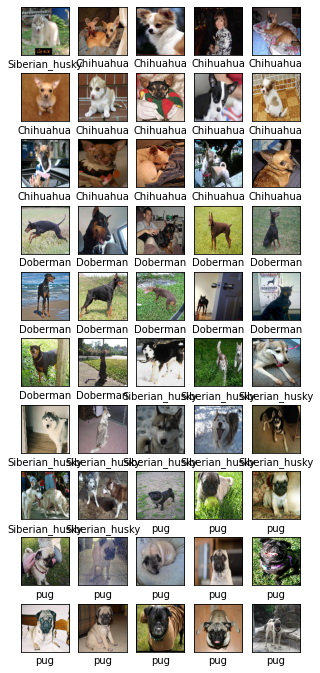

In [40]:
#ลองแสดงภาพ unseen พร้อมกับแปะคำตอบที่ได้จากโมเดลของเรา
plt.figure(figsize=(5,12))
for i in range(len(Predic)):
    plt.subplot(10,5,i+1) #กำหนดให้แสดงภาพ 10 แถว 5 คอลั่ม
    plt.xticks([])
    plt.yticks([])
    plt.imshow(Predic[i])#แสดงแต่ละภาพ โดยดึงมาจากข้อมูล feature ในตัวแปร Predic
    plt.xlabel(allClass[np.argmax(ans[i])])#แปะคำตอบ แต่เนื่องจากคำตอบจากโมเดเป็นแค่ตัวเลขตำแหน่ง เราจึงใช้ตัวเลขตำแหน่งนี้ มาชี้ข้อมูลคำตอบจริงๆที่เป็น string ที่เราเก็บไว้ในตัวแปร allClass)
plt.show()